# Case Study: Age in American Politics

In the last few section workbooks, we've reviewed Python basics, used a little `pandas`, wrangled and cleaned data, and carried out an exploratory data analysis where we generated a number of basic visualizations. This week, we'll extend this a bit futher, incorporating all that we've learned so far AND considering what we discussed in lecture last week. 

Your goal is to, without much structure provided, utilize the data provided to answer the question(s) we discussed in class last week: 

1. Does Congress have an age problem?
2. Is this problem exclusive to one of the two major parties?

The data you have to start with are available here: [congress-terms.csv](https://github.com/fivethirtyeight/data/tree/master/congress-age). They were used in [this piece](https://fivethirtyeight.com/features/both-republicans-and-democrats-have-an-age-problem/) at FiveThirtyEight. Note, there is an entry for every member of congress who has served at any point during a particular congress between January 1947 and Februrary 2014. One thing to keep in mind is the fact that elections have occurred since 2014 that are not included in this dataset. Getting up-to-date data will be explored in Part III of this notebook.


# Part I: Setup & Data

In this section you'll want to:
- **import any packages** you'll need for your analysis
    - Reminder: we'll be doing web scraping, so you'll need to include the following:
        - `import requests`
        - `import bs4` 
        - `from bs4 import BeautifulSoup`

- **get the data**:
    - read the Congress dataset in (URL: https://raw.githubusercontent.com/fivethirtyeight/data/master/congress-age/congress-terms.csv)
    - Read, understand, and run the webscraping code below

In [ ]:
# you'll probably need to install some packages!
# if so, un-comment the below command and it'll install the pacakge *in this notebook only*

# !pip install pandas_ply

  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ply: filename=pandas_ply-0.2.1-py3-none-any.whl size=15985 sha256=d5f0c5029c677eeb00dd36dd1e34b87ef57029266967cee61c359dfdbe0d017c
  Stored in directory: /Users/voytek/Library/Caches/pip/wheels/11/94/ce/a7482c4f73fd3b21e78df543a2c1eaf695f5c4f0bafab5cf76
Successfully built pandas_ply


In [3]:
# import pandas & numpy library
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# pandas-ply
from pandas_ply import install_ply, X
install_ply(pd)

# work with dates
import datetime

# packages helpful for webscraping
import requests
import bs4
from bs4 import BeautifulSoup

# if you attempt the API portion in Part III
# and change the package name if needed
# !pip install requests 
# if on datahub
# !pip install -user requests 
import requests
import json
from pandas.io.json import json_normalize

#improve resolution
%config InlineBackend.figure_format ='retina'

## Congress Data

For the Congress data, we have a CSV file ready and waiting for us to use, which is great.

In [4]:
# Get CSV directly from URL for Congress
politics = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/congress-age/congress-terms.csv')
politics.head()

,congress,chamber,bioguide,firstname,middlename,lastname,suffix,birthday,state,party,incumbent,termstart,age
0,80,house,M000112,Joseph,Jefferson,Mansfield,NaN,1861-02-09,TX,D,Yes,1947-01-03,85.9
1,80,house,D000448,Robert,Lee,Doughton,NaN,1863-11-07,NC,D,Yes,1947-01-03,83.2
2,80,house,S000001,Adolph,Joachim,Sabath,NaN,1866-04-04,IL,D,Yes,1947-01-03,80.7
3,80,house,E000023,Charles,Aubrey,Eaton,NaN,1868-03-29,NJ,R,Yes,1947-01-03,78.8
4,80,house,L000296,William,NaN,Lewis,NaN,1868-09-22,KY,R,No,1947-01-03,78.3


## US Age Data

Data about the mean/median age across US history is unreasonably difficult to find. We're resorting to web scraping here, which, as discussed in lecture can be a huge pain

In [5]:
# specify webpage we want to scrape 
wiki = 'https://en.wikipedia.org/wiki/Demography_of_the_United_States'
req = requests.get(wiki)
soup = BeautifulSoup(req.content, 'html') # get contents of web page

In [50]:
wikitables = soup.findAll("table", 'wikitable') # get tables

# extract the tables we want
tbl1 = wikitables[18]
tbl2 = wikitables[19]

In [57]:
# create some empty dataframes
# note the tables aren't the same size. ugh.
new_tbl1 = pd.DataFrame(columns=range(0,10), index = range(0,3)) # I know the size 
new_tbl2 = pd.DataFrame(columns=range(0,14), index = range(0,3))

In [58]:
# get the column names for our first table
ind=0
cols_list = []
for header in tbl1.find_all('tr'): # specify HTML tags
    header_name = header.find_all('th') # tag containing column names
    for head in header_name:
        cols_list.append(head.get_text()) # get the text from between the tags
new_tbl1.columns = [s.replace('\n','') for s in cols_list] # get rid of new line characters in column names

In [59]:
# fill in the contents for our first table
row_marker = -1
for row in tbl1.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td') # different tag than above for table contents
    for column in columns:
        new_tbl1.iat[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

In [60]:
# get the column names for the second table
ind=0
cols_list = []
for header in tbl2.find_all('tr'):
    header_name = header.find_all('th')
    for head in header_name:
        cols_list.append(head.get_text())
new_tbl2.columns = [s.replace('\n','') for s in cols_list] 

In [61]:
# fill in contents for second table
row_marker = -1
for row in tbl2.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        new_tbl2.iat[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

In [62]:
# of course there are new line characters to get rid of 
new_tbl2 = new_tbl2.replace(r'[\\n,\n]',' ', regex=True) 
new_tbl1 = new_tbl1.replace(r'[\\n,\n]',' ', regex=True) 

In [63]:
# set Years as index
new_tbl1.set_index(['Years'], inplace=True)
new_tbl2.set_index(['Years'], inplace=True)

In [66]:
# get it into tidy data format
age = new_tbl1.join(new_tbl2) # join two tables into one by index
age = age.transpose() # flip it so observations in rows
age = age.reset_index() # add year back in as a column
age.columns = ['year', 'age', 'median_males', 'median_females'] # rename columns
age = age.apply(pd.to_numeric, errors='coerce') # fix type of information stored
age.head() # flipping finally

,year,age,median_males,median_females
0,1820,16.7,16.6,16.8
1,1830,17.2,17.2,17.3
2,1840,17.8,17.9,17.8
3,1850,18.9,19.2,18.6
4,1860,19.4,19.8,19.1


# Part II: Descriptive & Exploratory Analyses

Once you understand your dataset, you'll want to:
- **understand** (describe) what's going on in the data
    - how many observations?
    - what variables do you have? what variable types are here
    - which will you need to answer the question?
- Carry out **EDA**
    - understand the relationships and trends for the variables in your dataset
    - generate exploratory visualizations
    - answer the exploratory questions we posed in lecture

## Descriptive Analysis

Here is where we want to understand our two datasets and the information stored within them.

### Congress Data

In [67]:
politics.shape

(18635, 13)

In [68]:
# look at typical values for quantitative variables
politics.describe()

,congress,age
count,18635.000000,18635.000000
mean,96.445989,53.313732
std,9.823429,10.678469
min,80.000000,25.000000
25%,88.000000,45.400000
50%,96.000000,53.000000
75%,105.000000,60.550000
max,113.000000,98.100000


In [69]:
#take a look at how party breaks down
politics.party.value_counts()

D     10290
R      8274
I        63
ID        4
AL        3
L         1
Name: party, dtype: int64

In [70]:
# take a look at chamber breakdown
politics.chamber.value_counts()

house     15083
senate     3552
Name: chamber, dtype: int64

In [71]:
# what about party broken down by chamber?
(politics
 .groupby('chamber')
 .party.value_counts())

chamber  party
house    D        8408
         R        6656
         I          13
         AL          3
         ID          2
         L           1
senate   D        1882
         R        1618
         I          50
         ID          2
Name: party, dtype: int64

Within party, there have been more Democrats in both the house _and_ the sentte relative to Rebublicans during this time period. 

### US Age Data

Let's look at the median age across the data we've web scraped.

In [72]:
age.shape

(22, 4)

In [73]:
age.describe()

,year,age,median_males,median_females
count,22.000000,22.000000,22.000000,22.000000
mean,1924.500000,26.418182,26.100000,26.686364
std,64.127663,7.047907,6.491166,7.616604
min,1820.000000,16.700000,16.600000,16.800000
25%,1872.500000,20.375000,20.450000,20.250000
50%,1925.000000,25.900000,26.250000,24.950000
75%,1977.500000,30.150000,29.700000,31.025000
max,2021.000000,38.800000,37.700000,39.800000


So, we have data from 22 different years. Across these years, the median age in the US was 26.4, with the median age being higher for females than males.

But that first table included many years that we don't have Congressional data for...so what if we just got 1950 to now.

In [74]:
# get overlap for years included in Congress dataset
age_sub = age.iloc[13:,]
age_sub

,year,age,median_males,median_females
13,1950,30.2,29.9,30.5
14,1960,29.6,28.7,30.4
15,1970,28.1,26.8,29.8
16,1980,30.0,28.8,31.2
17,1990,32.9,31.7,34.1
18,2000,35.3,34.0,36.5
19,2010,37.2,35.8,38.5
20,2018,38.2,36.9,39.5
21,2021,38.8,37.7,39.8


In [75]:
age_sub.describe()

,year,age,median_males,median_females
count,9.000000,9.000000,9.000000,9.000000
mean,1988.777778,33.366667,32.255556,34.477778
std,25.572337,4.105180,3.984693,4.168866
min,1950.000000,28.100000,26.800000,29.800000
25%,1970.000000,30.000000,28.800000,30.500000
50%,1990.000000,32.900000,31.700000,34.100000
75%,2010.000000,37.200000,35.800000,38.500000
max,2021.000000,38.800000,37.700000,39.800000


## Exploratory Analysis

Since we want to look at a trend of age over time, a line plot is a really great place to start. To visualize the trend, we'll use `sns.lineplot` from the seaborn package and provide that function with the variables we're interested in visualizing over time.

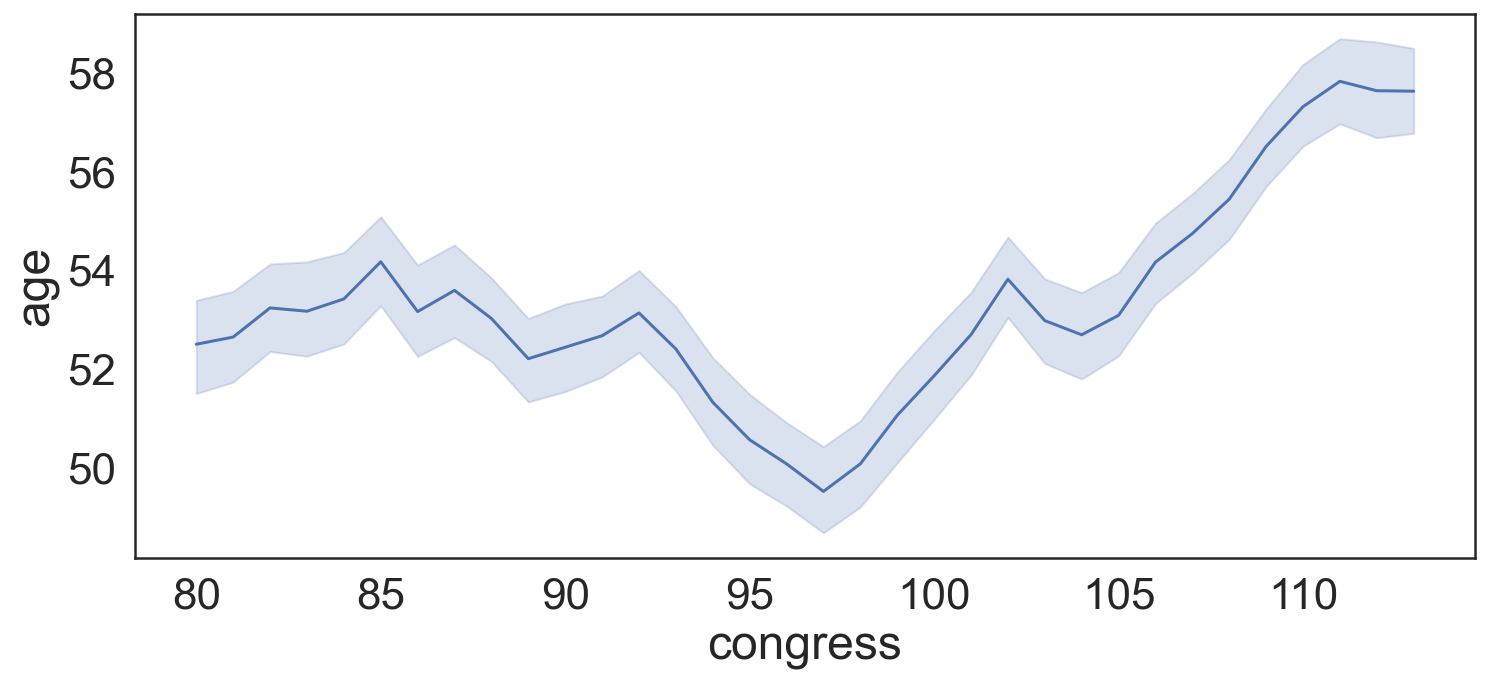

In [76]:
# general age trend in Congress
# note: you could use fivethirtyeight style since the data came from FiveThirtyEight
# style.use('fivethirtyeight') 
# here we'll just stick to the white background
sns.lineplot(x = "congress", y = "age", data = politics);

The average age in Congress has clearly increased in recent years. But, is this driven by one party over another? Let's break this down by party to see. Additionally, we'd rather the years be on the x-axis, rather than the congress, as we have a better understanding of years. To do this, we'll use the `datetime` package.

As a general note, the line on the plot is the average, the shaded light blue demonstrates the standard error around the estimate, giving us an idea about variability in the estimates.

In [77]:
## get year column in there for x-axis
politics['year'] = pd.to_datetime(politics['termstart']).dt.year

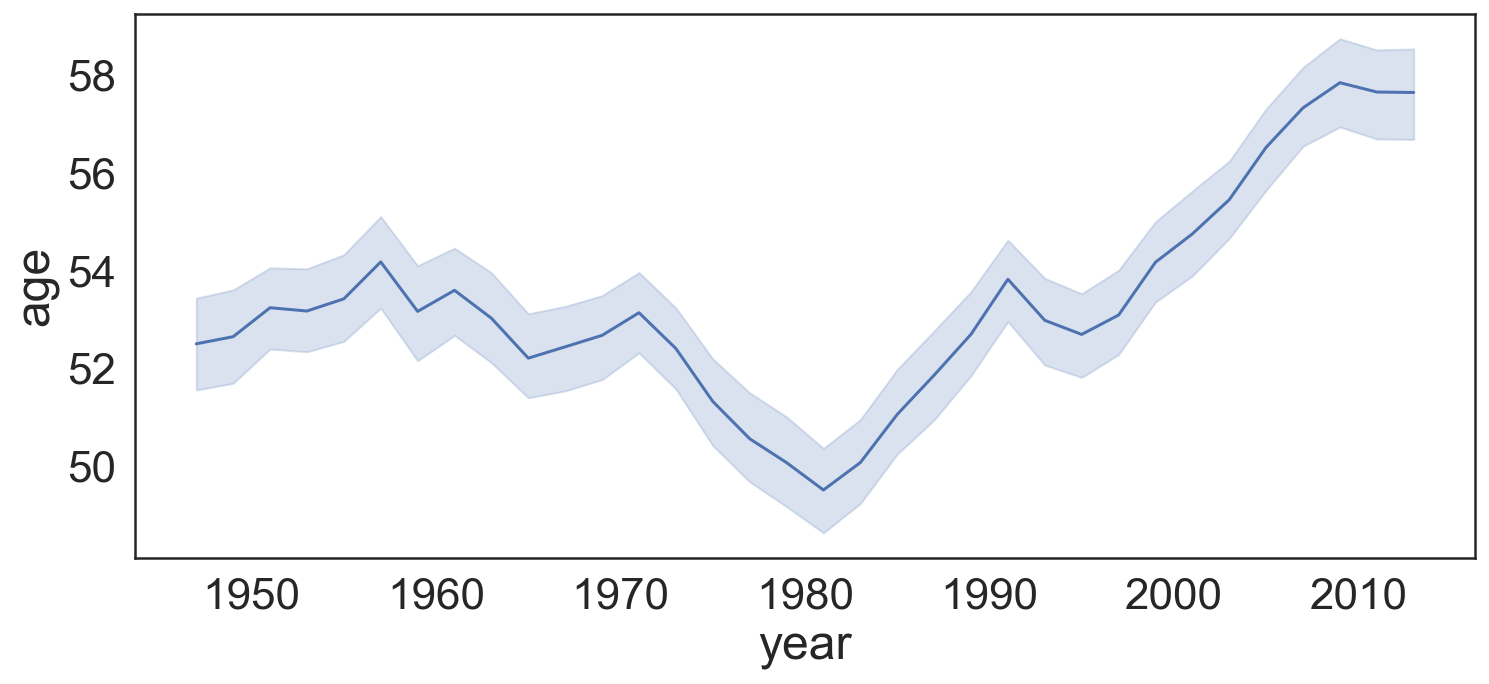

In [78]:
 sns.lineplot(x = "year", y = "age", data = politics);

Well, what about the same time period for median US population? Note that I've opted to use the subset of data on ages that overlaps with the time period above

Remeber that we already have group-level data, so we'll just see a single line, as we don't have information about variability for these data:

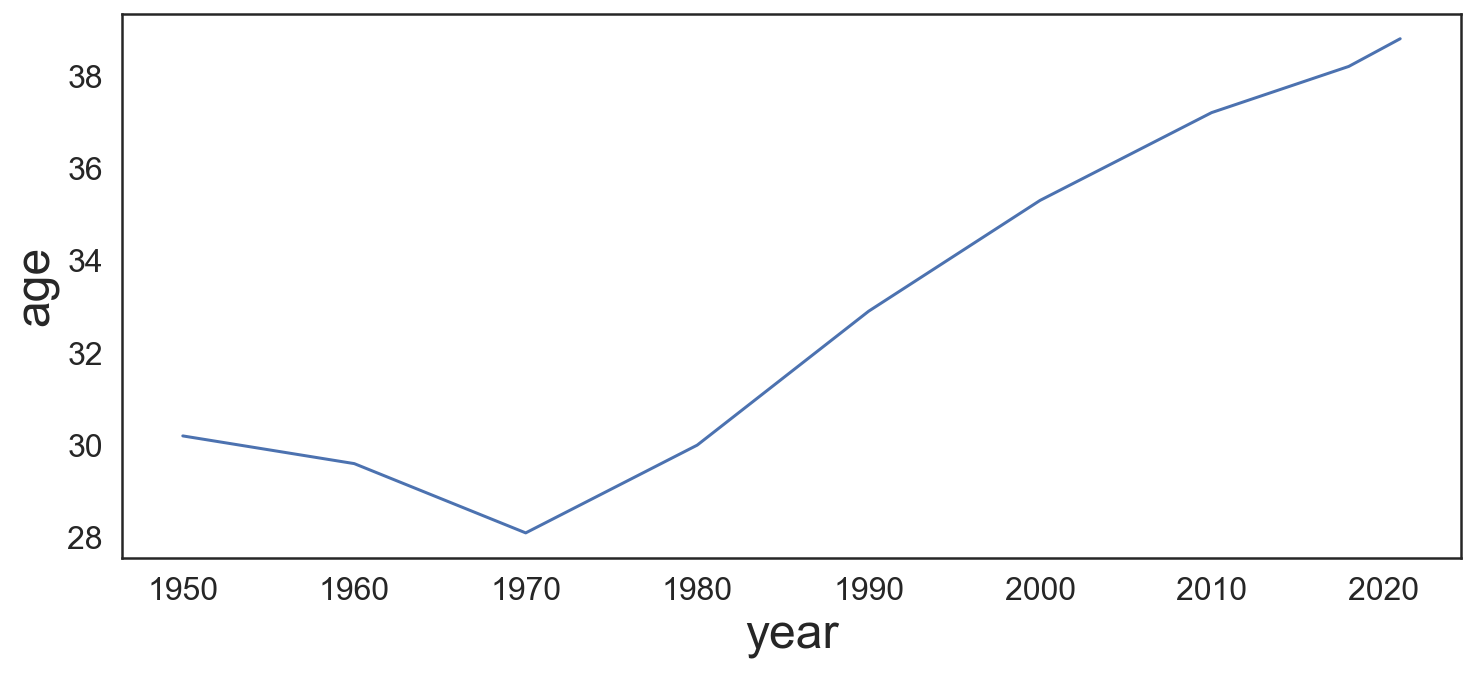

In [79]:
# age trend of US population over time    
sns.lineplot(x = "year", y = "age", data = age_sub)
plt.tick_params(labelsize=16);

So, the data also increase overall but we don't see a dip in the 80's like we do above and the increase is pretty steady - certainly less variability than above. Also, the values are different. Here all the median ages are in the 30s, while the average age of Congress members is in the 50s.

Even this may not be the best comparison, though. We'd likely want to look at the median age of adults over 25 (for comparison with the House) and over 30 (for comparison with the Senate). You're welcome to go search for those data!

Having made our initial overall comparison, let's start looking at the breakdowns we were interested in. 

Does age differ by...
- party? 
- chamber?

We'll start by looking at party differences:

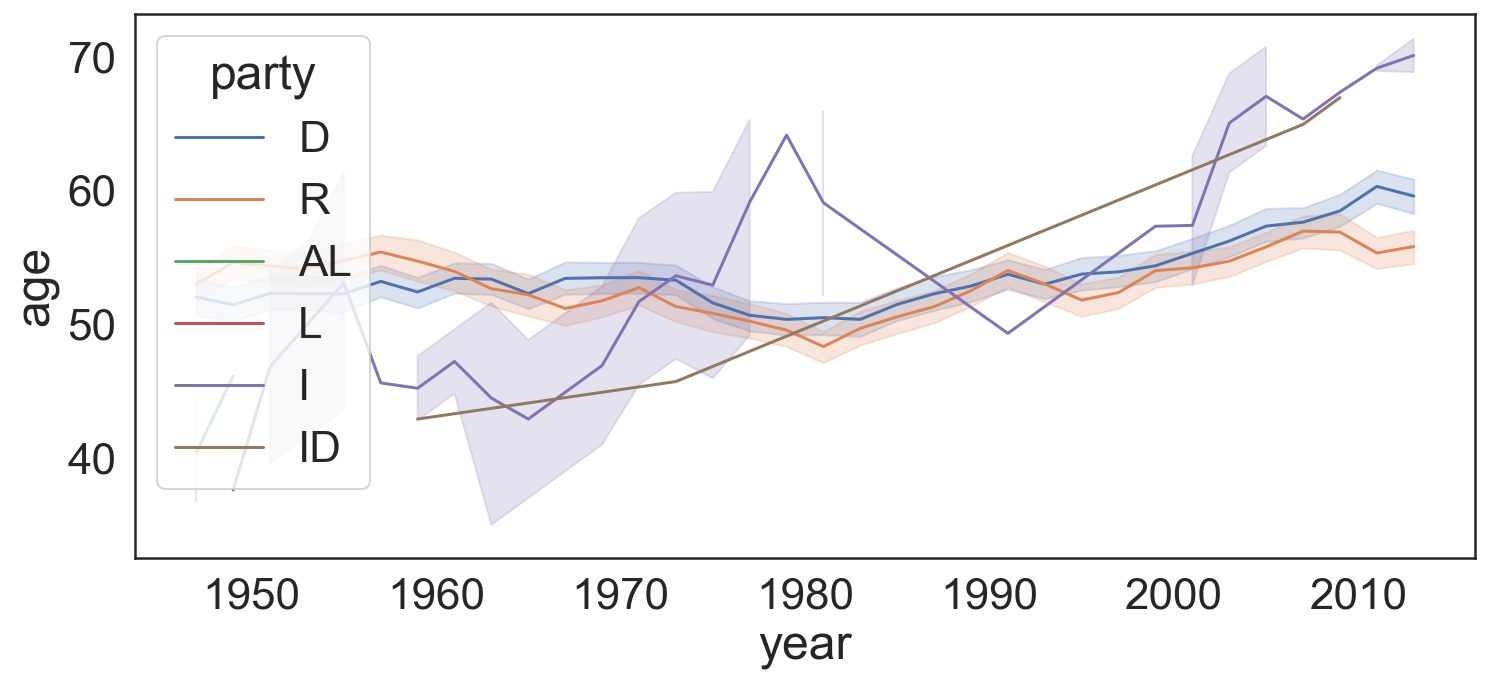

In [86]:
# age trend by party 
sns.lineplot(x = "year", y = "age", hue = "party",  data = politics);

What we see here is that while there are individuals in Congress over history from more than the two main parties, these lines represent very few actual individuals (<50 in any given third party...see EDA above). So, for the rest of this analysis, we're just going to focus on the two main parties: Democrats and Republicans.

## Filter to only include Dems and Repubs

In [87]:
## filter to only include dems and repubs
dem_rep = politics[(politics.party == 'D') | (politics.party == 'R')]
dem_rep.shape

(18564, 14)

In [88]:
## specify a color pallete
unique = dem_rep["party"].unique()
palette = dict(zip(unique, sns.color_palette(["#0000CD","#ff0000"])))
palette.update({"Total":"k"})

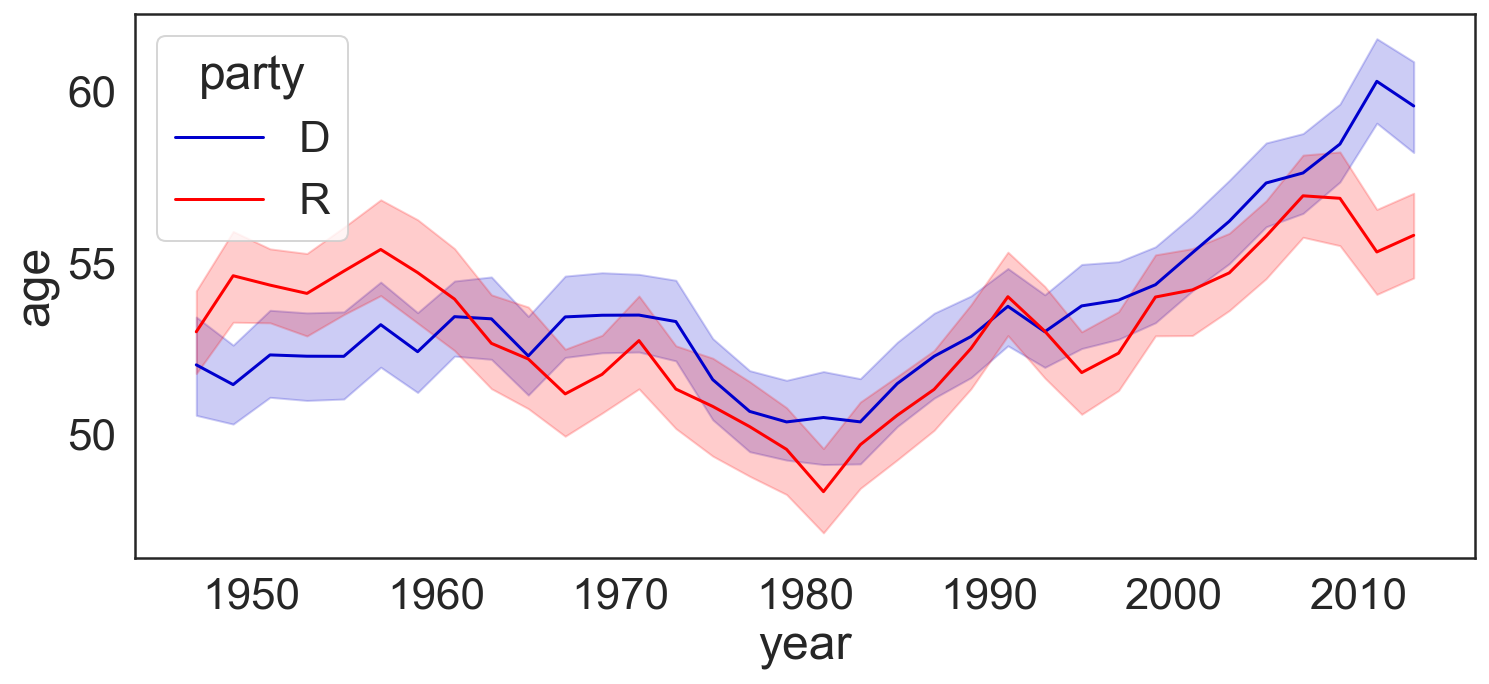

In [89]:
# age trend by party 
sns.lineplot(x = "year", 
             y = "age", 
             hue = "party",  
             data = dem_rep,
             palette = palette);

After filtering to the two main parties, we see that age is increasing in both parties, following the general overall trend. We note, however, that since the mid-1960s, Democrats in Congress have been being older, on average, than Republicans. We note that 1990 appeared to show a slight reversal in this trend, but with a spike in age overall.

## Does this trend differ by chamber?

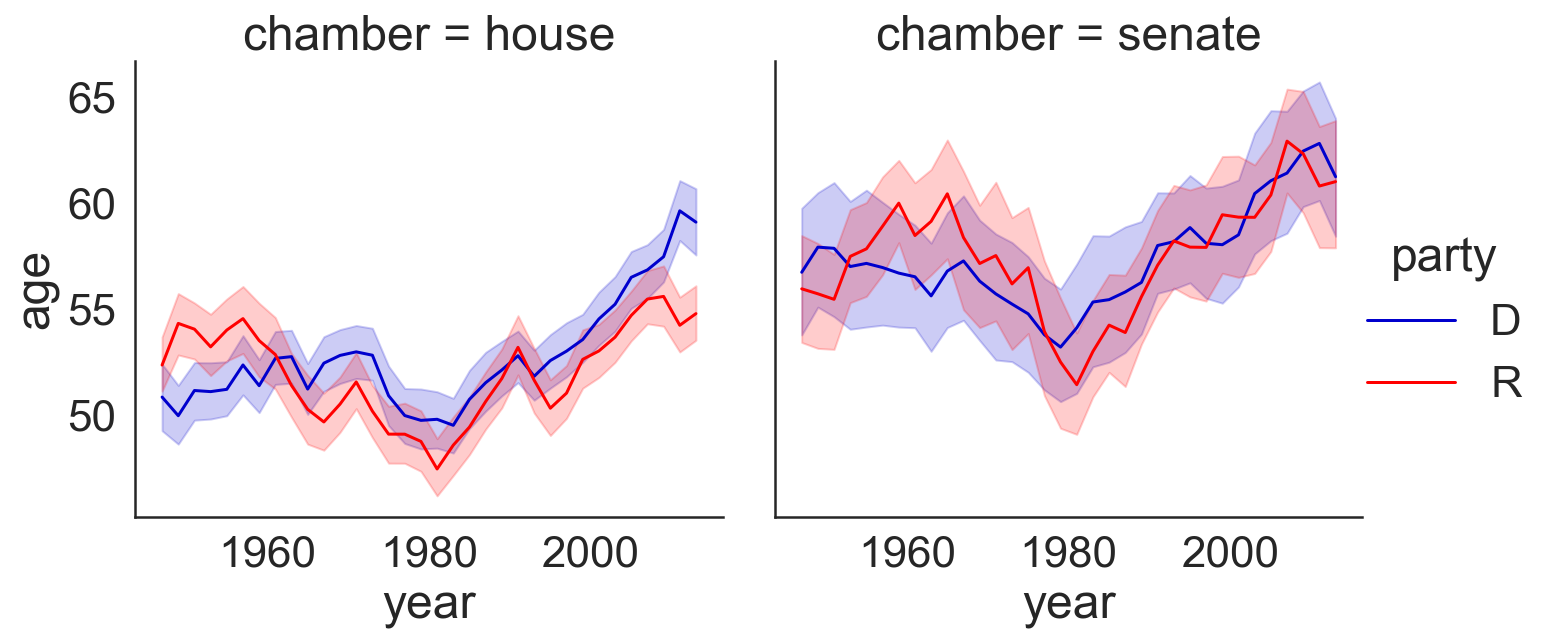

In [90]:
sns.relplot(x = "year", 
             y = "age", 
             hue = "party",
             col = 'chamber',
             kind = "line",
             data = dem_rep, 
             palette = palette);

When we break this down further by chamber of congress, we see that the separation between Democrats and Republicans is largely driven by age differences in the House. Age in the Senate does not appear to be different between parties. The overall increase in age over recent history, however, is seen in both houses. Note that the age spike in 1990 in hte House is not seen in the Senate.

## Effect of Incumbents?

We know that people often spend multiple terms in Congress. Here, we look to see if this trend in age and party is driven by incumbents. To determine this, we filter to a dataset that only includes non-incumbents. This dataset includes 2920 individuals (of the original 15K).

In [91]:
#just include non-incumbents
new_members = dem_rep[(dem_rep.incumbent == 'No')]
new_members.shape

(2920, 14)

In [92]:
## specify a color pallete
unique = new_members["party"].unique()
palette = dict(zip(unique, sns.color_palette(["#0000CD","#ff0000"])))
palette.update({"Total":"k"})
print(palette)

{'R': (0.0, 0.0, 0.803921568627451), 'D': (1.0, 0.0, 0.0), 'Total': 'k'}


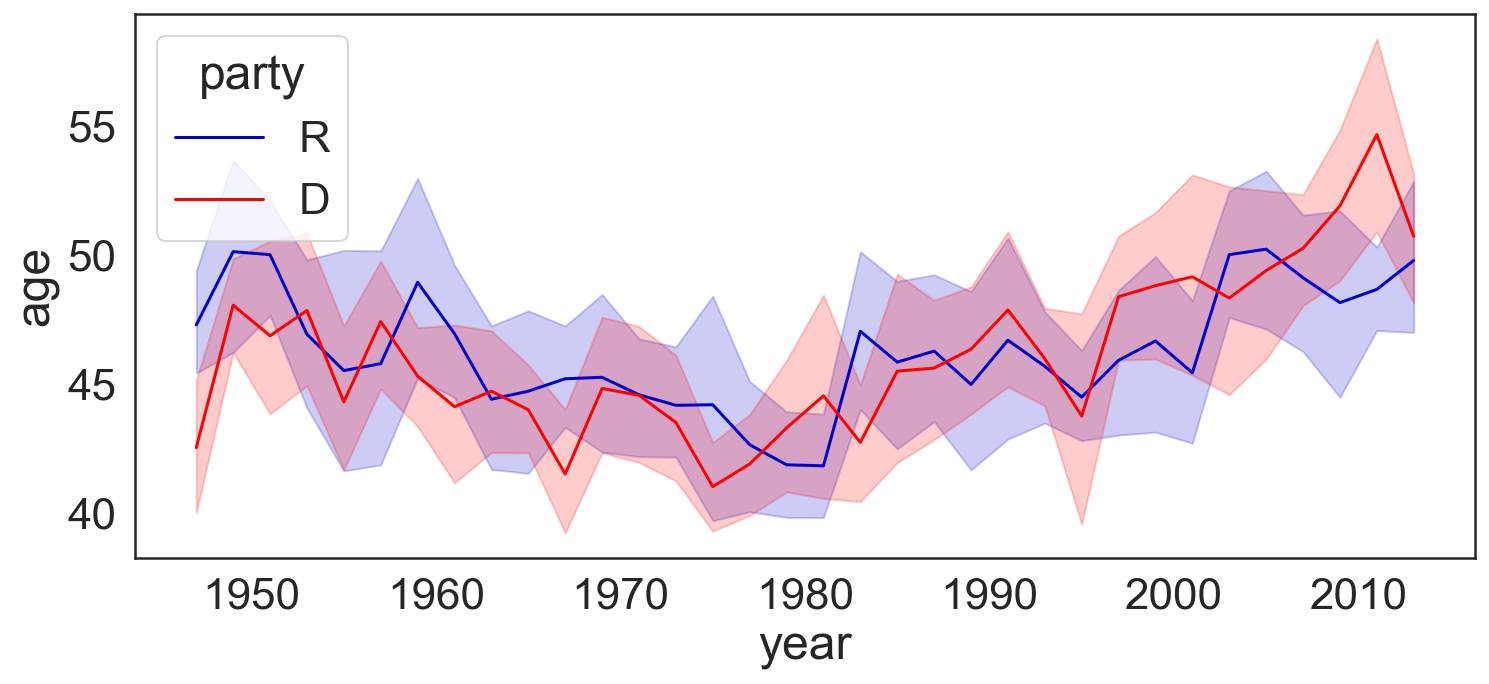

In [93]:
sns.lineplot(x = "year", 
             y = "age", 
             hue = "party",  
             data = new_members, 
             palette = palette);

When we restrict our analysis to only new members of Congress each year, the trend is much less pronounced and the separation between the partices is not nearly as pronounced. This suggests that the increase in age over time in Congress may have something to do with incumbency, something that seems to be more pronounced in Democrats than Republicans. This would have to be investigated more closely.